<a href="https://colab.research.google.com/github/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/blob/main/Clasificacion_validacion_y_metricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='dark'>**Clasificación: Validación de modelos y métricas de evaluación**</h1>

### Proyecto

Una empresa de financiamiento de automóviles está atravesando una situación complicada, con una alta demanda para una flota reducida de vehículos y un alto número de morosos, lo que está generando grandes pérdidas para la empresa.

Nosotros fuimos contratados para buscar mejoras en la identificación de morosos. El análisis de los clientes actualmente se realiza de forma manual, cliente por cliente, lo que consume mucho tiempo y, aun así, la detección de morosos es muy imprecisa.

Nuestra tarea es utilizar los datos proporcionados por la empresa para **clasificar** a los clientes en cumplidores y morosos.

In [29]:
#Para la manipulación de datos
import pandas as pd
import numpy as np

#Para la división en conjunto de datos
from sklearn.model_selection import train_test_split

#Para en el entrenamiento de modelos ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Para la evaluación de modelos ML
from sklearn.metrics import confusion_matrix #Para obtener los valores de la matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay #Para visualizar la matriz de confusión

## <font color='dark'>Clasificando los datos</h1>

### Creando un modelo inicial

In [ ]:
'''
import chardet
with open('/content/prestacar.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)
'''

MacRoman


In [17]:
url = 'https://github.com/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/raw/refs/heads/main/prestacar.csv'
datos = pd.read_csv(url, encoding='utf-8') #Se empleó utf-8 para importar correctamente el nombre de las columnas
datos.head()

,ingresos_cliente,anualidad_prestamo,años_casa_propia,telefono_trab,evaluacion_ciudad,score_1,score_2,score_3,score_social,cambio_telefono,moroso
0,12600.0,3569.400000,12.157324,1,2.0,0.057153,0.527227,0.513171,0.117428,2545.0,0
1,9000.0,2722.188351,7.000000,0,2.0,0.657661,0.285898,0.614414,0.222700,495.0,0
2,15750.0,4477.500000,12.000000,0,2.0,0.501213,0.695423,0.513171,0.117428,1212.0,0
3,9000.0,1309.050000,12.157324,0,3.0,0.501213,0.155973,0.513171,0.117428,515.0,0
4,7650.0,1125.000000,12.157324,0,2.0,0.294328,0.152076,0.513171,0.117428,162.0,0


In [18]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54025 entries, 0 to 54024
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ingresos_cliente    54025 non-null  float64
 1   anualidad_prestamo  54025 non-null  float64
 2   años_casa_propia    54025 non-null  float64
 3   telefono_trab       54025 non-null  int64  
 4   evaluacion_ciudad   54025 non-null  float64
 5   score_1             54025 non-null  float64
 6   score_2             54025 non-null  float64
 7   score_3             54025 non-null  float64
 8   score_social        54025 non-null  float64
 9   cambio_telefono     54025 non-null  float64
 10  moroso              54025 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 4.5 MB


In [19]:
#Separando las variables explicativas de la variable de respuesta
X = datos.drop(columns='moroso')
y = datos['moroso']

#Entrenamiento y evaluación del modelo de arbol clasificador
modelo_arbol = DecisionTreeClassifier()
modelo_arbol.fit(X, y)
print(f'El modelo de árbo tiene una exactitud de {modelo_arbol.score(X, y)}')

El modelo de árbo tiene una exactitud de 1.0


### Validando el modelo

Evaluar el modelo con los mismos datos utilizados en el entrenamiento no es recomendable. Es necesario que la evaluación se realice con datos independientes.  

Evaluar el modelo con los propios datos de entrenamiento sería equivalente a entregar un examen con las preguntas y las respuestas a una persona y, al momento de evaluarla nuevamente, entregarle un examen con las mismas preguntas y opciones. Se espera que esa persona obtenga un buen resultado, ya que ya ha visto las respuestas y ha memorizado el resultado. Esto es diferente de haber aprendido la materia a partir de ese examen y luego presentar una prueba con contenido similar y obtener un resultado positivo.  

Con el objetivo de verificar la capacidad de generalización de un modelo, debemos dividir el conjunto de datos en tres partes: datos de entrenamiento, validación y prueba.  

- El **conjunto de entrenamiento** se utiliza para entrenar los modelos. A partir de este conjunto, los modelos identifican patrones en los datos.  

- El **conjunto de validación** se emplea para evaluar el desempeño de diferentes modelos con datos nuevos que no fueron utilizados en el entrenamiento.  

- El **conjunto de prueba** se mantiene separado desde el inicio para simular datos del mundo real. No se utiliza en ninguna etapa del entrenamiento ni de la validación, sirviendo como una estimación de la capacidad del modelo elegido para generalizar y predecir nuevos datos.

<a href="https://ibb.co/9H2Z1HZ5"><img src="https://i.ibb.co/0yZs6ysb/datos-train-test.png" alt="datos-train-test" border="0"></a>

In [20]:
#Se divide los datos en 3 conjuntos: Entrenamiento(64% = 75%*85%), validación(21% = 25%*85%), prueba(15%)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15, random_state=5, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=5, stratify=y)

In [21]:
#Entrenamiento y validación del modelo de árbol con profundida exahustiva
modelo_arbol = DecisionTreeClassifier(random_state=2)
modelo_arbol.fit(X_train, y_train)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol.score(X_train, y_train)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol.score(X_val, y_val)}')

El modelo de árbo tiene una exactitud de 1.0
El modelo de árbo tiene una exactitud de 0.847312951833464


In [22]:
#Entrenamiento y validación del modelo de árbol con 10 niveles de profundidad
modelo_arbol = DecisionTreeClassifier(max_depth=10, random_state=2)
modelo_arbol.fit(X_train, y_train)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol.score(X_train, y_train)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol.score(X_val, y_val)}')

El modelo de árbo tiene una exactitud de 0.9206445993031359
El modelo de árbo tiene una exactitud de 0.9055831373573731


### Evaluando el modelo

In [23]:
y_pred_val = modelo_arbol.predict(X_val)

In [24]:
matriz_confusion = confusion_matrix(y_val, y_pred_val)
matriz_confusion

array([[10355,   124],
       [  960,    42]])

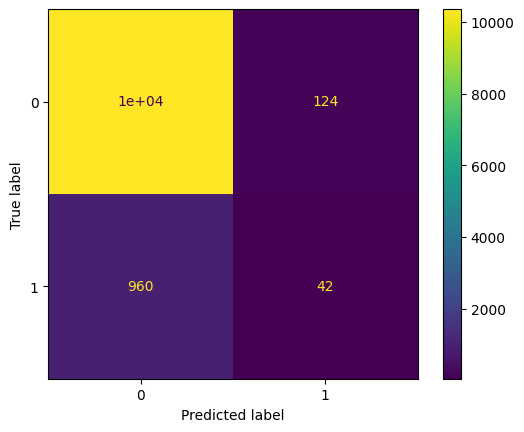

In [25]:
'''
El siguiente código devuelve un objeto tipo AxesSubplot. El punto y coma
silencia la salida textual, solicitando a Jupyter que muestre únicamente la
visualización del gráfico.
'''
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion)
visualizacion.plot();

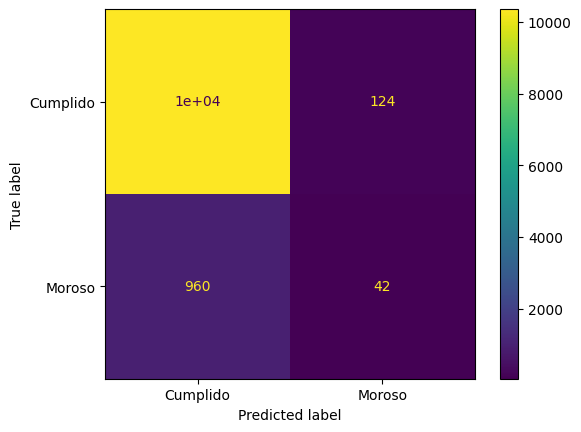

In [26]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['Cumplido','Moroso'])
visualizacion.plot();

### Desafío 1 - aula 1
Utilizamos durante la clase el algoritmo de árbol de decisión, pero la biblioteca Scikit-Learn tiene varios otros métodos de clasificación que pueden ser utilizados en nuestro proyecto. Como desafío, utiliza el algoritmo Random Forest para crear un modelo y evaluar el desempeño con la precisión y la matriz de confusión, y compara los resultados con el resultado del árbol de decisión.

Como un consejo, revisa la documentación del algoritmo [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier).

#### Entrenamiento del modelo

In [30]:
modelo_randomforest = RandomForestClassifier(max_depth=10, random_state=2)
modelo_randomforest.fit(X_train, y_train)
print(f'El modelo de randomforest con datos de entrenamiento tiene una exactitud de {modelo_randomforest.score(X_train, y_train)}')
print(f'El modelo de randomforest con datos de validación tiene una exactitud de {modelo_randomforest.score(X_val, y_val)}')

El modelo de árbo tiene una exactitud de 0.9151567944250871
El modelo de árbo tiene una exactitud de 0.9127253723543245


#### Evaluando del modelo

In [31]:
y_pred_val = modelo_randomforest.predict(X_val)
matriz_confusion = confusion_matrix(y_val, y_pred_val)

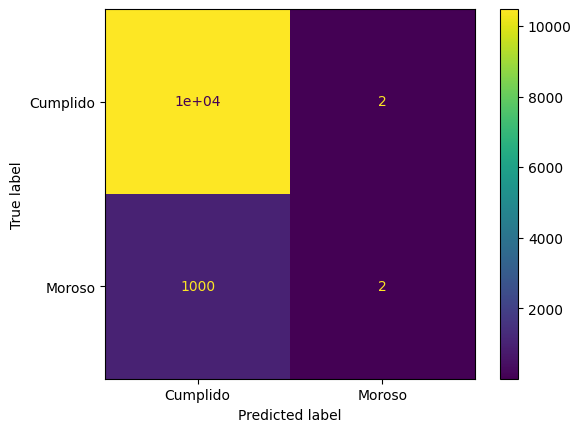

In [32]:
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['Cumplido','Moroso'])
visualizacion.plot();

### Desafío 2 - aula 1
Vamos a practicar el contenido que se presentó en la clase a partir de algunas actividades, pero utilizando un conjunto de datos diferente con datos de pacientes a ser diagnosticados con diabetes o no. Los desafíos siguen una secuencia de tareas, sirviendo como un proyecto secundario. Para realizar los desafíos, descarga la base de datos desde este [enlace](https://github.com/alura-es-cursos/2162-clasificacion-validacion-de-modelos-y-metricas/blob/desafios/diabetes.csv).

1. Para la construcción de un modelo de machine learning se necesitan datos. Como tarea inicial, realiza la lectura de la base de datos de diabetes y divide los datos en variables explicativas y variable objetivo (x e y). La variable objetivo es la columna que quieres clasificar, que contiene la información de si el paciente tiene o no diabetes. Las variables explicativas son todas las columnas excepto la de diabetes. La separación de los datos se puede hacer con la selección de columnas con pandas.

2. Una etapa muy importante en proyectos de clasificación es la validación de los modelos, para identificar si hay una generalización del modelo para datos nuevos. Realiza la división de los datos entre entrenamiento, validación y prueba. Utiliza el 5% de los datos para prueba y con el resto, deja el 25% para validación. En el momento de la separación, usa el parámetro stratify a partir de la variable objetivo para mantener la proporción de los datos.

3. La etapa de modelado de datos consiste en utilizar un algoritmo capaz de identificar patrones en los datos y clasificar los valores. A partir del modelo es posible extraer una tasa de acierto para entender su desempeño. Crea 2 modelos utilizando los algoritmos DecisionTreeClassifier y RandomForestClassifier y evalúa la precisión de entrenamiento y prueba, eligiendo el valor 3 para el parámetro max_depth del algoritmo DecisionTreeClassifier y el valor 2 para el max_depth del algoritmo RandomForestClassifier, para que los modelos no se especialicen demasiado en el patrón de los datos de entrenamiento.

4. La tasa de acierto generalmente no proporciona información suficiente para entender el comportamiento del modelo. La matriz de confusión es una herramienta más completa, capaz de proporcionar los aciertos y errores del modelo para cada clase. Construye una matriz de confusión para cada uno de los modelos para evaluar el desempeño de la predicción. Para construir la matriz, usa el método predict para generar las predicciones de los valores y comparar con los valores reales de la base de datos.

#### Importación de los datos

In [34]:
'''
import chardet
with open('/content/diabetes.csv','rb') as f:
  diccionario = chardet.detect(f.read())
  encode = diccionario['encoding']

print(encode)
'''

ascii


In [35]:
url_desafio = 'https://github.com/JLuceroVasquez/clasificacion-validacion-de-modelos-y-metricas/raw/refs/heads/main/desafio/diabetes.csv'
datos_desafio = pd.read_csv(url_desafio, encoding='ascii')
datos_desafio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   glicemia                  394 non-null    int64  
 1   presion_sanguinea         394 non-null    int64  
 2   grasa_subcutanea_triceps  394 non-null    int64  
 3   insulina                  394 non-null    float64
 4   imc                       394 non-null    float64
 5   diabetes                  394 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 18.6 KB


In [38]:
X_d = datos_desafio.drop(columns='diabetes')
y_d = datos_desafio.diabetes

#### División en 3 conjuntos de datos

In [39]:
X_d, X_test_d, y_d, y_test_d = train_test_split(X_d, y_d, test_size=0.05, random_state=5, stratify=y_d)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_d, y_d, test_size=0.25, random_state=5, stratify=y_d)

#### Entrenamiento de 2 modelos de clasificación

In [40]:
modelo_arbol_d = DecisionTreeClassifier(max_depth=3, random_state=2)
modelo_arbol_d.fit(X_train_d, y_train_d)
print(f'El modelo de árbol con datos de entrenamiento tiene una exactitud de {modelo_arbol_d.score(X_train_d, y_train_d)}')
print(f'El modelo de árbol con datos de validación tiene una exactitud de {modelo_arbol_d.score(X_val_d, y_val_d)}')

El modelo de árbol tiene una exactitud de 0.7571428571428571
El modelo de árbol tiene una exactitud de 0.776595744680851


In [41]:
modelo_randomforest_d = RandomForestClassifier(max_depth=2, random_state=2)
modelo_randomforest_d.fit(X_train_d, y_train_d)
print(f'El modelo de randomforest con datos de entrenamiento tiene una exactitud de {modelo_randomforest_d.score(X_train_d, y_train_d)}')
print(f'El modelo de randomforest con datos de validación tiene una exactitud de {modelo_randomforest_d.score(X_val_d, y_val_d)}')

El modelo de randomforest tiene una exactitud de 0.7357142857142858
El modelo de randomforest tiene una exactitud de 0.6914893617021277


#### Matriz de confusión

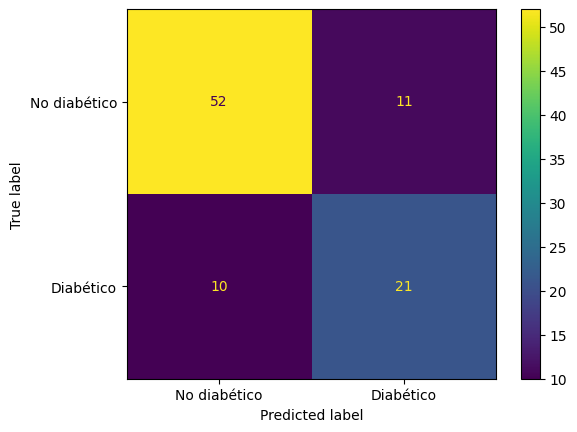

In [42]:
y_pred_val_d = modelo_arbol_d.predict(X_val_d)
matriz_confusion = confusion_matrix(y_val_d, y_pred_val_d)
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['No diabético','Diabético'])
visualizacion.plot();

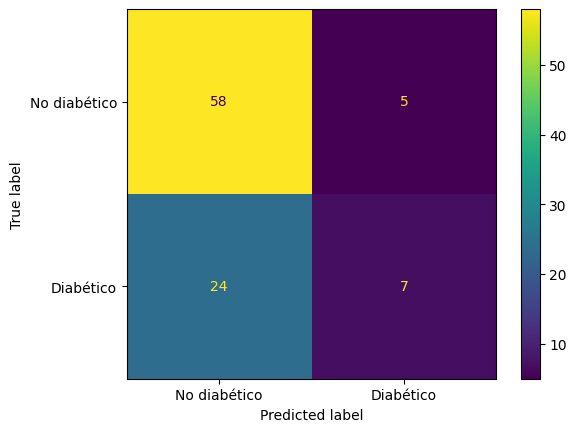

In [43]:
y_pred_val_d = modelo_randomforest_d.predict(X_val_d)
matriz_confusion = confusion_matrix(y_val_d, y_pred_val_d)
visualizacion = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=['No diabético','Diabético'])
visualizacion.plot();

## <font color='dark'>Métricas de evaluación</h1>

### Exactitud, precisión y recall (sensibilidad).

<a href="https://ibb.co/351SbY7t"><img src="https://i.ibb.co/wZypqrRD/matriz-confusion.png" alt="matriz-confusion" border="0"></a>

<a href="https://imgbb.com/"><img src="https://i.ibb.co/6Jp6rKyC/Captura-de-tela-2025-03-22-120744.png" alt="Captura-de-tela-2025-03-22-120744" border="0"></a>

### Curva ROC

In [27]:
from IPython.display import Image
Image(url='https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/cutoff.gif')

Fuente: [paulvanderlaken.com](https://paulvanderlaken.com/2019/08/16/roc-auc-precision-and-recall-visually-explained/)




### Curva de  precisión x sensibilidad

In [28]:
Image(url='https://paulvanderlaken.com/wp-content/uploads/2019/08/roc.gif')

Fuente: [paulvanderlaken.com](https://paulvanderlaken.com/2019/08/16/roc-auc-precision-and-recall-visually-explained/)


### Informe de métricas

## <font color='dark'> Validación cruzada</h1>

### Usando KFold

La validación del modelo de clasificación a partir de la separación de los datos en conjuntos de entrenamiento y validación hace que el resultado dependa en gran medida de esta división. Puede suceder que, de forma aleatoria, el patrón de los datos de validación sea diferente al de los datos de entrenamiento, lo que podría llevar a obtener un resultado mucho mejor o mucho peor que la realidad simplemente por suerte o mala suerte.  

Teniendo esto en cuenta, es posible utilizar la **validación cruzada**, una estrategia más consistente y ampliamente utilizada en proyectos de *machine learning*.  

En la validación cruzada, en lugar de separar los datos en entrenamiento y validación una sola vez, se dividen en varias partes de igual tamaño. En cada una de estas divisiones, se usa una parte para validación y todas las demás para entrenamiento. Este proceso se repite hasta que todas las partes hayan sido utilizadas tanto para validación como para entrenamiento.  

Se generará un modelo para cada una de estas divisiones y la evaluación del desempeño se realizará promediando la métrica de cada modelo. Esto elimina la dependencia de la separación de los datos, ya que hay una mayor variación en la selección de los mismos y se obtiene un valor medio.  

Generalmente, se utilizan 5 o 10 partes. Un número mayor no suele ser necesario, ya que implica un procesamiento más costoso, y valores menores ya ayudan a mitigar el problema de la selección de los datos.

<a href="https://ibb.co/KcBtshJR"><img src="https://i.ibb.co/nq4X1mFZ/train-y-validacion.png" alt="train-y-validacion" border="0"></a>

### Validación cruzada con sensibilidad

### Estratificando los datos

## <font color='dark'>Balanceo de los datos</h1>

### Oversampling

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#id1

### Pipeline para validación

### Undersampling

https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.NearMiss.html

### Probando el modelo